In [18]:
import tensorflow as tf
from tensorflow import keras
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from sklearn.manifold import TSNE

In [2]:
def plot_image(image): #black and white images
    plt.imshow(image, cmap="binary")
    plt.axis("off")

### PCA analysis with linear autocoder

3D dataset

In [4]:
np.random.seed(4)

def generate_3d_data(m, w1=0.1, w2=0.3, noise=0.1):
    angles = np.random.rand(m) * 3 * np.pi / 2 - 0.5
    data = np.empty((m, 3))
    data[:, 0] = np.cos(angles) + np.sin(angles)/2 + noise * np.random.randn(m) / 2
    data[:, 1] = np.sin(angles) * 0.7 + noise * np.random.randn(m) / 2
    data[:, 2] = data[:, 0] * w1 + data[:, 1] * w2 + noise * np.random.randn(m)
    return data

X_train = generate_3d_data(60)
X_train = X_train - X_train.mean(axis=0, keepdims=0)

Let's make autocoder

In [7]:
np.random.seed(42)
tf.random.set_seed(42)

encoder = keras.models.Sequential([keras.layers.Dense(2, input_shape=[3])])
decoder = keras.models.Sequential([keras.layers.Dense(3, input_shape=[2])])
autoencoder = keras.models.Sequential([encoder, decoder])

autoencoder.compile(loss="mse", optimizer=keras.optimizers.SGD(learning_rate=1.5))

In [8]:
history = autoencoder.fit(X_train, X_train, epochs=20)

Epoch 1/20
2/2 [==============================] - 1s 12ms/step - loss: 0.9902
Epoch 2/20
2/2 [==============================] - 0s 9ms/step - loss: 0.1120
Epoch 3/20
2/2 [==============================] - 0s 5ms/step - loss: 0.0397
Epoch 4/20
2/2 [==============================] - 0s 9ms/step - loss: 0.0494
Epoch 5/20
2/2 [==============================] - 0s 6ms/step - loss: 0.0568
Epoch 6/20
2/2 [==============================] - 0s 5ms/step - loss: 0.0246
Epoch 7/20
2/2 [==============================] - 0s 5ms/step - loss: 0.0177
Epoch 8/20
2/2 [==============================] - 0s 7ms/step - loss: 0.0083
Epoch 9/20
2/2 [==============================] - 0s 5ms/step - loss: 0.0059
Epoch 10/20
2/2 [==============================] - 0s 6ms/step - loss: 0.0052
Epoch 11/20
2/2 [==============================] - 0s 6ms/step - loss: 0.0051
Epoch 12/20
2/2 [==============================] - 0s 4ms/step - loss: 0.0049
Epoch 13/20
2/2 [==============================] - 0s 5ms/step - loss: 0

In [9]:
codings = encoder.predict(X_train)

2/2 [==============================] - 0s 2ms/step


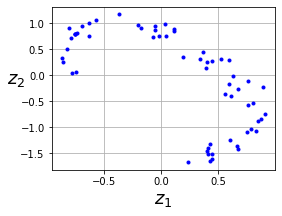

In [10]:
fig = plt.figure(figsize=(4,3))
plt.plot(codings[:,0], codings[:, 1], "b.")
plt.xlabel("$z_1$", fontsize=18)
plt.ylabel("$z_2$", fontsize=18, rotation=0)
plt.grid(True)
plt.show()

### Stacked autocoders / Deep autocoders
Using this we want to find some patterns and generalize out input. Model can't be to perfect, becaouse it's gone perfectly encode and decode our data in that situation

MNIST dataset

In [11]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_train_full = X_train_full.astype(np.float32) / 255
X_test = X_test.astype(np.float32) / 255
X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

4422102/4422102 [==============================] - 0s 0us/step


In [12]:
def rounded_accuracy(y_true, y_pred):
    return keras.metrics.binary_accuracy(tf.round(y_true), tf.round(y_pred))

In [14]:
tf.random.set_seed(42)
np.random.seed(42)

stacked_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(100, activation="selu"),
    keras.layers.Dense(30, activation="selu"),
])
stacked_decoder = keras.models.Sequential([
    keras.layers.Dense(100, activation="selu", input_shape=[30]),
    keras.layers.Dense(28 * 28, activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])
stacked_ae = keras.models.Sequential([stacked_encoder, stacked_decoder])
stacked_ae.compile(loss="binary_crossentropy",
                   optimizer=keras.optimizers.SGD(learning_rate=1.5), metrics=[rounded_accuracy])
history = stacked_ae.fit(X_train, X_train, epochs=20,
                         validation_data=[X_valid, X_valid])

Epoch 1/20
1719/1719 [==============================] - 8s 4ms/step - loss: 0.3384 - rounded_accuracy: 0.8869 - val_loss: 0.3132 - val_rounded_accuracy: 0.9091
Epoch 2/20
1719/1719 [==============================] - 7s 4ms/step - loss: 0.3058 - rounded_accuracy: 0.9149 - val_loss: 0.3055 - val_rounded_accuracy: 0.9188
Epoch 3/20
1719/1719 [==============================] - 7s 4ms/step - loss: 0.2996 - rounded_accuracy: 0.9204 - val_loss: 0.3006 - val_rounded_accuracy: 0.9167
Epoch 4/20
1719/1719 [==============================] - 7s 4ms/step - loss: 0.2957 - rounded_accuracy: 0.9238 - val_loss: 0.2953 - val_rounded_accuracy: 0.9263
Epoch 5/20
1719/1719 [==============================] - 7s 4ms/step - loss: 0.2928 - rounded_accuracy: 0.9264 - val_loss: 0.2933 - val_rounded_accuracy: 0.9276
Epoch 6/20
1719/1719 [==============================] - 7s 4ms/step - loss: 0.2910 - rounded_accuracy: 0.9280 - val_loss: 0.2913 - val_rounded_accuracy: 0.9297
Epoch 7/20
1719/1719 [==================

In [15]:
def show_reconstructions(model, images=X_valid, n_images=5):
    reconstructions = model.predict(images[:n_images])
    fig = plt.figure(figsize=(n_images * 1.5, 3))
    for image_index in range(n_images):
        plt.subplot(2, n_images, 1 + image_index)
        plot_image(images[image_index])
        plt.subplot(2, n_images, 1 + n_images + image_index)
        plot_image(reconstructions[image_index])

1/1 [==============================] - 0s 30ms/step


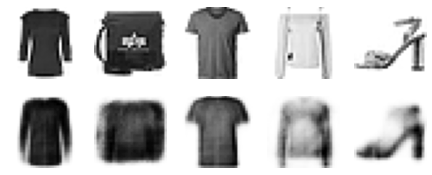

In [17]:
show_reconstructions(stacked_ae)    # top row - oryginal values, low row - encoded and decoded values

Better version to visualize

In [19]:
np.random.seed(42)

X_valid_compressed = stacked_encoder.predict(X_valid)
tsne = TSNE()
X_valid_2D = tsne.fit_transform(X_valid_compressed)
X_valid_2D = (X_valid_2D - X_valid_2D.min()) / (X_valid_2D.max() - X_valid_2D.min())

157/157 [==============================] - 1s 2ms/step


c:\Python310\lib\site-packages\sklearn\manifold\_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
c:\Python310\lib\site-packages\sklearn\manifold\_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


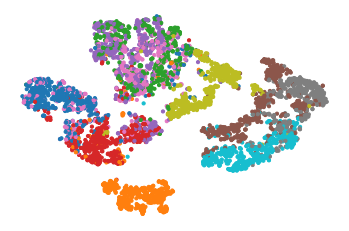

In [20]:
plt.scatter(X_valid_2D[:, 0], X_valid_2D[:, 1], c=y_valid, s=10, cmap="tab10")
plt.axis("off")
plt.show()

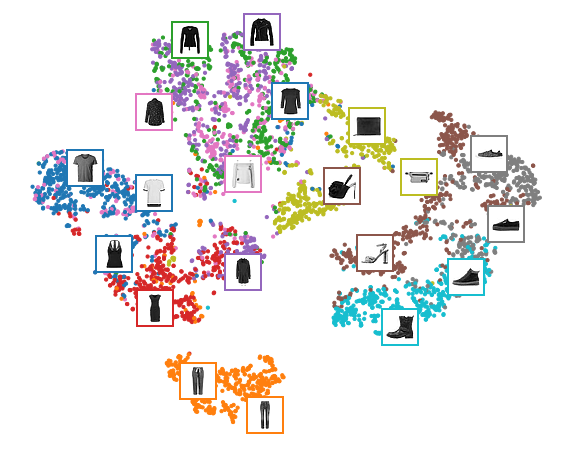

In [21]:
# adapted from https://scikit-learn.org/stable/auto_examples/manifold/plot_lle_digits.html
plt.figure(figsize=(10, 8))
cmap = plt.cm.tab10
plt.scatter(X_valid_2D[:, 0], X_valid_2D[:, 1], c=y_valid, s=10, cmap=cmap)
image_positions = np.array([[1., 1.]])
for index, position in enumerate(X_valid_2D):
    dist = np.sum((position - image_positions) ** 2, axis=1)
    if np.min(dist) > 0.02: # if distance is long enougth
        image_positions = np.r_[image_positions, [position]]
        imagebox = mpl.offsetbox.AnnotationBbox(
            mpl.offsetbox.OffsetImage(X_valid[index], cmap="binary"),
            position, bboxprops={"edgecolor": cmap(y_valid[index]), "lw": 2})
        plt.gca().add_artist(imagebox)
plt.axis("off")
plt.show()

Tying weights

In [23]:
class DenseTranspose(keras.layers.Layer):
    def __init__(self, dense, activation=None, **kwargs):
        self.dense = dense
        self.activation = keras.activations.get(activation)
        super().__init__(**kwargs)
    def build(self, batch_input_shape):
        self.biases = self.add_weight(name="bias",
                                      shape=[self.dense.input_shape[-1]],
                                      initializer="zeros")
        super().build(batch_input_shape)
    def call(self, inputs):
        z = tf.matmul(inputs, self.dense.weights[0], transpose_b=True)
        return self.activation(z + self.biases)

In [25]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

dense_1 = keras.layers.Dense(100, activation="selu")
dense_2 = keras.layers.Dense(30, activation="selu")

tied_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    dense_1,
    dense_2
])

tied_decoder = keras.models.Sequential([
    DenseTranspose(dense_2, activation="selu"),
    DenseTranspose(dense_1, activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])

tied_ae = keras.models.Sequential([tied_encoder, tied_decoder])

tied_ae.compile(loss="binary_crossentropy",
                optimizer=keras.optimizers.SGD(learning_rate=1.5), metrics=[rounded_accuracy])
history = tied_ae.fit(X_train, X_train, epochs=10,
                      validation_data=[X_valid, X_valid])

Epoch 1/10
1719/1719 [==============================] - 11s 6ms/step - loss: 0.3277 - rounded_accuracy: 0.8955 - val_loss: 0.3085 - val_rounded_accuracy: 0.9062
Epoch 2/10
1719/1719 [==============================] - 9s 5ms/step - loss: 0.2970 - rounded_accuracy: 0.9229 - val_loss: 0.2941 - val_rounded_accuracy: 0.9290
Epoch 3/10
1719/1719 [==============================] - 10s 6ms/step - loss: 0.2908 - rounded_accuracy: 0.9287 - val_loss: 0.2947 - val_rounded_accuracy: 0.9197
Epoch 4/10
1719/1719 [==============================] - 10s 6ms/step - loss: 0.2878 - rounded_accuracy: 0.9315 - val_loss: 0.2876 - val_rounded_accuracy: 0.9345
Epoch 5/10
1719/1719 [==============================] - 9s 5ms/step - loss: 0.2859 - rounded_accuracy: 0.9332 - val_loss: 0.2865 - val_rounded_accuracy: 0.9320
Epoch 6/10
1719/1719 [==============================] - 9s 5ms/step - loss: 0.2845 - rounded_accuracy: 0.9344 - val_loss: 0.2862 - val_rounded_accuracy: 0.9349
Epoch 7/10
1719/1719 [===============

1/1 [==============================] - 0s 119ms/step


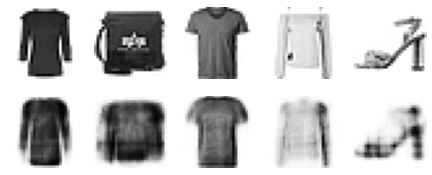

In [26]:
show_reconstructions(tied_ae)
plt.show()

### Replacing dense layers with convolutional layers

In [28]:
tf.random.set_seed(42)
np.random.seed(42)

conv_encoder = keras.models.Sequential([
    keras.layers.Reshape([28, 28, 1], input_shape=[28, 28]),
    keras.layers.Conv2D(16, kernel_size=3, padding="SAME", activation="selu"),
    keras.layers.MaxPool2D(pool_size=2),
    keras.layers.Conv2D(32, kernel_size=3, padding="SAME", activation="selu"),
    keras.layers.MaxPool2D(pool_size=2),
    keras.layers.Conv2D(64, kernel_size=3, padding="SAME", activation="selu"),
    keras.layers.MaxPool2D(pool_size=2)
])
conv_decoder = keras.models.Sequential([
    keras.layers.Conv2DTranspose(32, kernel_size=3, strides=2, padding="VALID", activation="selu",
                                 input_shape=[3, 3, 64]),
    keras.layers.Conv2DTranspose(16, kernel_size=3, strides=2, padding="SAME", activation="selu"),
    keras.layers.Conv2DTranspose(1, kernel_size=3, strides=2, padding="SAME", activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])
conv_ae = keras.models.Sequential([conv_encoder, conv_decoder])

conv_ae.compile(loss="binary_crossentropy", optimizer=keras.optimizers.SGD(learning_rate=1.0),
                metrics=[rounded_accuracy])
history = conv_ae.fit(X_train, X_train, epochs=5,
                      validation_data=[X_valid, X_valid])

Epoch 1/5
1719/1719 [==============================] - 48s 27ms/step - loss: 0.3026 - rounded_accuracy: 0.9186 - val_loss: 0.2833 - val_rounded_accuracy: 0.9321
Epoch 2/5
1719/1719 [==============================] - 41s 24ms/step - loss: 0.2756 - rounded_accuracy: 0.9415 - val_loss: 0.2730 - val_rounded_accuracy: 0.9456
Epoch 3/5
1719/1719 [==============================] - 41s 24ms/step - loss: 0.2710 - rounded_accuracy: 0.9461 - val_loss: 0.2710 - val_rounded_accuracy: 0.9481
Epoch 4/5
1719/1719 [==============================] - 53s 31ms/step - loss: 0.2685 - rounded_accuracy: 0.9487 - val_loss: 0.2680 - val_rounded_accuracy: 0.9509
Epoch 5/5
1719/1719 [==============================] - 55s 32ms/step - loss: 0.2668 - rounded_accuracy: 0.9506 - val_loss: 0.2673 - val_rounded_accuracy: 0.9511


1/1 [==============================] - 0s 189ms/step


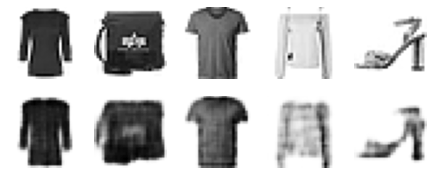

In [29]:
show_reconstructions(conv_ae)
plt.show()

### Denoising stack autocoders

In [32]:
tf.random.set_seed(42)
np.random.seed(42)

denoising_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.GaussianNoise(0.2),
    keras.layers.Dense(100, activation="selu"),
    keras.layers.Dense(30, activation="selu")
])
denoising_decoder = keras.models.Sequential([
    keras.layers.Dense(100, activation="selu", input_shape=[30]),
    keras.layers.Dense(28 * 28, activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])
denoising_ae = keras.models.Sequential([denoising_encoder, denoising_decoder])
denoising_ae.compile(loss="binary_crossentropy", optimizer=keras.optimizers.SGD(learning_rate=1.0),
                     metrics=[rounded_accuracy])
history = denoising_ae.fit(X_train, X_train, epochs=10,
                           validation_data=[X_valid, X_valid])

Epoch 1/10
1719/1719 [==============================] - 9s 5ms/step - loss: 0.3487 - rounded_accuracy: 0.8781 - val_loss: 0.3170 - val_rounded_accuracy: 0.9069
Epoch 2/10
1719/1719 [==============================] - 9s 5ms/step - loss: 0.3118 - rounded_accuracy: 0.9101 - val_loss: 0.3080 - val_rounded_accuracy: 0.9173
Epoch 3/10
1719/1719 [==============================] - 8s 5ms/step - loss: 0.3045 - rounded_accuracy: 0.9164 - val_loss: 0.3014 - val_rounded_accuracy: 0.9200
Epoch 4/10
1719/1719 [==============================] - 8s 5ms/step - loss: 0.3004 - rounded_accuracy: 0.9200 - val_loss: 0.2980 - val_rounded_accuracy: 0.9243
Epoch 5/10
1719/1719 [==============================] - 8s 5ms/step - loss: 0.2975 - rounded_accuracy: 0.9225 - val_loss: 0.2953 - val_rounded_accuracy: 0.9258
Epoch 6/10
1719/1719 [==============================] - 8s 5ms/step - loss: 0.2953 - rounded_accuracy: 0.9244 - val_loss: 0.2934 - val_rounded_accuracy: 0.9288
Epoch 7/10
1719/1719 [==================

1/1 [==============================] - 0s 93ms/step


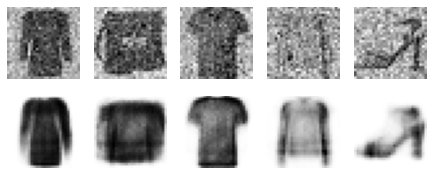

In [33]:
tf.random.set_seed(42)
np.random.seed(42)

noise = keras.layers.GaussianNoise(0.2)
show_reconstructions(denoising_ae, noise(X_valid, training=True))
plt.show()

### Generative Adversarial Networks - GAN
One network generate some new images, on the other hand secound network try to predict that it is fake. They train each other

In [37]:
def plot_multiple_images(images, n_cols=None):
    n_cols = n_cols or len(images)
    n_rows = (len(images) - 1) // n_cols + 1
    if images.shape[-1] == 1:
        images = np.squeeze(images, axis=-1)
    plt.figure(figsize=(n_cols, n_rows))
    for index, image in enumerate(images):
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(image, cmap="binary")
        plt.axis("off")

In [34]:
np.random.seed(42)
tf.random.set_seed(42)

codings_size = 30

generator = keras.models.Sequential([
    keras.layers.Dense(100, activation="selu", input_shape=[codings_size]),
    keras.layers.Dense(150, activation="selu"),
    keras.layers.Dense(28 * 28, activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])
discriminator = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(150, activation="selu"),
    keras.layers.Dense(100, activation="selu"),
    keras.layers.Dense(1, activation="sigmoid")
])
gan = keras.models.Sequential([generator, discriminator])

In [35]:
discriminator.compile(loss="binary_crossentropy", optimizer="rmsprop")
discriminator.trainable = False
gan.compile(loss="binary_crossentropy", optimizer="rmsprop")

In [36]:
batch_size = 32
dataset = tf.data.Dataset.from_tensor_slices(X_train).shuffle(1000)
dataset = dataset.batch(batch_size, drop_remainder=True).prefetch(1)

In [38]:
def train_gan(gan, dataset, batch_size, codings_size, n_epochs=50):
    generator, discriminator = gan.layers
    for epoch in range(n_epochs):
        print("Epoch number {}/{}".format(epoch + 1, n_epochs))              
        for X_batch in dataset:
            # Faze 1. Learning discriminator
            noise = tf.random.normal(shape=[batch_size, codings_size])
            generated_images = generator(noise)
            X_fake_and_real = tf.concat([generated_images, X_batch], axis=0)
            y1 = tf.constant([[0.]] * batch_size + [[1.]] * batch_size)
            discriminator.trainable = True
            discriminator.train_on_batch(X_fake_and_real, y1)
            # Faze 2. Learning generator
            noise = tf.random.normal(shape=[batch_size, codings_size])
            y2 = tf.constant([[1.]] * batch_size)
            discriminator.trainable = False
            gan.train_on_batch(noise, y2)
        plot_multiple_images(generated_images, 8)                     
        plt.show()                                                    

Epoch number 1/1


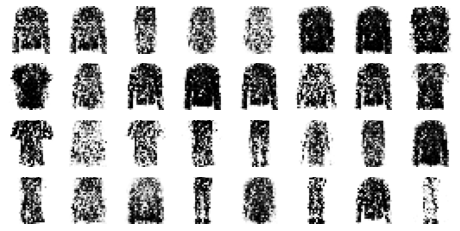

In [39]:
train_gan(gan, dataset, batch_size, codings_size, n_epochs=1)

Epoch number 1/10


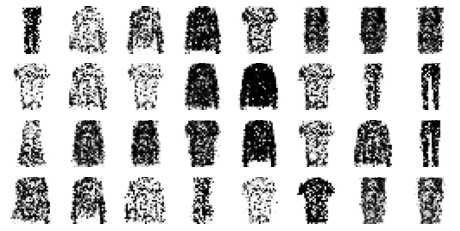

Epoch number 2/10


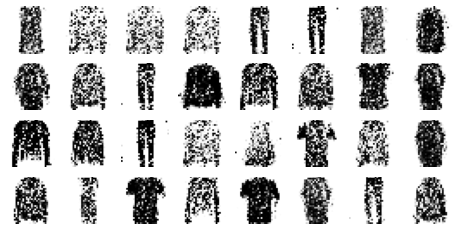

Epoch number 3/10


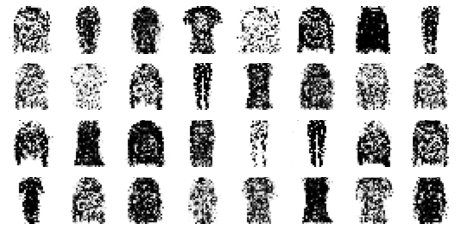

Epoch number 4/10


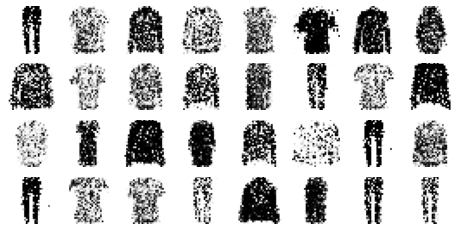

Epoch number 5/10


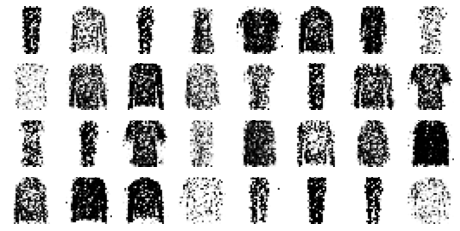

Epoch number 6/10


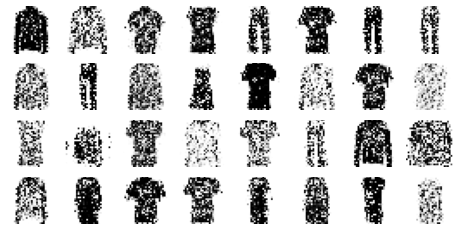

Epoch number 7/10


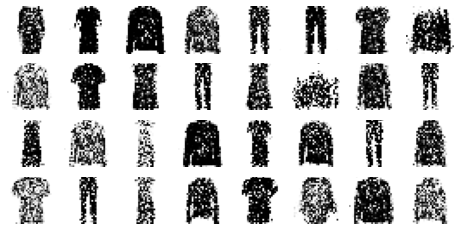

Epoch number 8/10


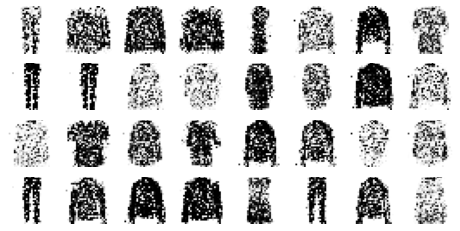

Epoch number 9/10


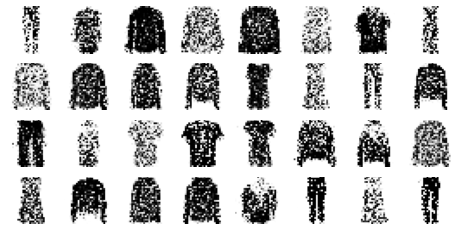

Epoch number 10/10


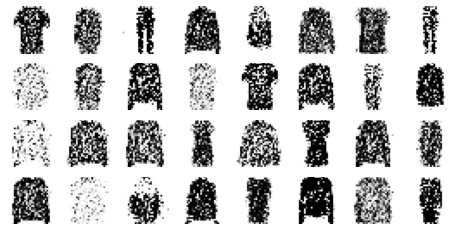

In [41]:
train_gan(gan, dataset, batch_size, codings_size, n_epochs=10)

### Deep convolutional GAN
based on article from 2015

In [42]:
tf.random.set_seed(42)
np.random.seed(42)

codings_size = 100

generator = keras.models.Sequential([
    keras.layers.Dense(7 * 7 * 128, input_shape=[codings_size]),
    keras.layers.Reshape([7, 7, 128]),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2DTranspose(64, kernel_size=5, strides=2, padding="SAME",
                                 activation="selu"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2DTranspose(1, kernel_size=5, strides=2, padding="SAME",
                                 activation="tanh"),
])
discriminator = keras.models.Sequential([
    keras.layers.Conv2D(64, kernel_size=5, strides=2, padding="SAME",
                        activation=keras.layers.LeakyReLU(0.2),
                        input_shape=[28, 28, 1]),
    keras.layers.Dropout(0.4),
    keras.layers.Conv2D(128, kernel_size=5, strides=2, padding="SAME",
                        activation=keras.layers.LeakyReLU(0.2)),
    keras.layers.Dropout(0.4),
    keras.layers.Flatten(),
    keras.layers.Dense(1, activation="sigmoid")
])
gan = keras.models.Sequential([generator, discriminator])

In [43]:
discriminator.compile(loss="binary_crossentropy", optimizer="rmsprop")
discriminator.trainable = False
gan.compile(loss="binary_crossentropy", optimizer="rmsprop")

In [44]:
X_train_dcgan = X_train.reshape(-1, 28, 28, 1) * 2. - 1. # change size and scale

In [47]:
batch_size = 32
dataset = tf.data.Dataset.from_tensor_slices(X_train_dcgan)
dataset = dataset.shuffle(1000)
dataset = dataset.batch(batch_size, drop_remainder=True).prefetch(1)

Epoch number 1/1


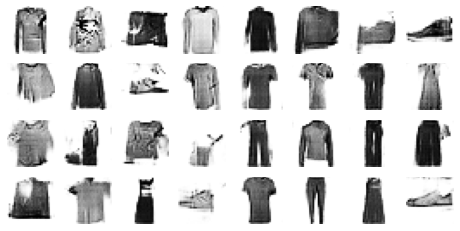

In [49]:
train_gan(gan, dataset, batch_size, codings_size,  n_epochs=1) # takes long time on CPU